In [1]:
from lib.training import train, eval
from lib.data import get_data_chest_x_ray_image
from lib.utils import get_device
from torch import nn 
import torch
import torch.optim as opt
import pandas as pd

c:\Users\matheus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ExperimentConfig:
    def __init__(self, name, model_fn, loss_fn, optimizer_fn):
        self.name = name
        self.model_fn = model_fn
        self.loss_fn = loss_fn
        self.optimizer_fn = optimizer_fn

In [25]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from lib.data import TransformDataset
from lib.utils import plot_evolution, plot_confusion_matrix

def generate_stat_dataframe(path_to_history : dict, save_name, device):
    import torch
    from collections import defaultdict
    import pandas as pd
    
    cp_paths = os.listdir(path_to_history)
    cp_paths = [os.path.join(path_to_history, x) for x in cp_paths if ('best' not in x) and ('.parquet' not in x)] ## filtering desirable file type
    cp_paths = [x for x in cp_paths if os.path.isfile(x)] ## filtering just files

    df_save_path = os.path.join(path_to_history, f'{save_name}.parquet')
    df_data = defaultdict(list)

    for cp_path in cp_paths: 
        checkpoint = torch.load(cp_path, weights_only=False, map_location=device)
        history = checkpoint['metadata']['history']
        
        prefix, ext = os.path.splitext(cp_path)
        fold_number = int(prefix.split('fold=')[-1])
        
        columns = list(history.keys())
        for c in columns: df_data[c].extend(history[c])
        
        repeated_fold_list = [fold_number]*(len(history[columns[0]]))
        df_data['fold'].extend(repeated_fold_list)
        
    results_df = pd.DataFrame(data=df_data)
    results_df.to_parquet(path=df_save_path, compression='gzip')
    
    return results_df

def prepare_dataloaders(*datasets, batch_size=64, shuffle=True):
    num_workers = max(1, os.cpu_count() - 1)
    dataloader_list = []
    for dataset in datasets:
        new_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=True
        )
        dataloader_list.append(new_dataloader)
    return dataloader_list

def get_my_metrics(device, n_classes):
    import torchmetrics
    from lib.metrics import MetricCollection
    
    metrics = MetricCollection(device=device)
    metrics.register('accuracy', torchmetrics.Accuracy(task='multiclass', num_classes=n_classes))
    metrics.register('precision', torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='macro'))
    metrics.register('recall', torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='macro'))
    metrics.register('f1_score', torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='macro'))
    
    return metrics


def generate_fold_plots(results_df: pd.DataFrame, target_columns, title, save_path=None, highlight=None):
    
    for fold in results_df['fold'].unique().tolist():
        fold_slice = results_df[results_df['fold'] == fold].reset_index(drop=True)
        column_values = [fold_slice[tc].tolist() for tc in target_columns]
        
        best_epochs = None
        if highlight is not None:      
            best_epochs = []
            for tc in target_columns:
                if highlight == 'max':
                    best_epochs.append(fold_slice[tc].values.argmax() + 1)
                elif highlight == 'min':
                    best_epochs.append(fold_slice[tc].values.argmin() + 1)
        
        if save_path is not None:
            os.makedirs(save_path, exist_ok=True)
            save_full_path = os.path.join(save_path, f'{title}_fold={fold}.png')
        else:
            save_full_path = None
        
        plot_evolution(
            y_values=column_values, 
            y_labels=target_columns, 
            title=title,
            xlabel='Epochs', 
            ylabel='Values', 
            path=save_full_path, 
            #vlines=best_epochs
        )    
        
    return 

def load_only_model_state(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    return checkpoint['model_state_dict']

def experiment(config : ExperimentConfig, data_dict, device, metrics, freeze=False, epochs=30, warmup=5, patience=10, mode='train', best_by='val_f1_score', best_by_mode='max'):
    
    save_path = f'experiments/{config.name}_folder'
    images_path = os.path.join(save_path, 'images/')
    
    os.makedirs(save_path, exist_ok=True)   
    os.makedirs(images_path, exist_ok=True)
    
    if mode == 'train' or mode == 'train+results':
        
        folds = data_dict['folds']
        base_dataset = data_dict['base_dataset']
        train_transform = data_dict['train_transform']
        test_transform = data_dict['test_transform']
        
        for fold_idx, (train_idx, val_idx) in enumerate(folds):
            print(f"\n--- Fold {fold_idx+1} ---")
            
            model = config.model_fn().to(device=device)
            
            if freeze: model.freeze()
            else : model.unfreeze()

            optimizer = config.optimizer_fn(model.parameters())
            loss_fn = config.loss_fn()
            
            train_subset = Subset(base_dataset, train_idx)
            val_subset = Subset(base_dataset, val_idx)

            train_dataset = TransformDataset(train_subset, train_transform)
            val_dataset = TransformDataset(val_subset, test_transform)

            train_dataloader, val_dataloader = prepare_dataloaders(train_dataset, val_dataset)
            
            save_name = f'{config.name}_fold={fold_idx+1}.pt'
            
            history, model = train(
                model, train_dataloader, val_dataloader,
                loss_fn, optimizer,
                save_path=save_path, save_name=save_name,
                device=device, metrics=metrics, verbose=True,
                epochs=epochs, warmup=warmup, patience=patience,
            )
            
    elif mode == 'results' or mode == 'train+results':
        from sklearn.metrics import classification_report
        
        print('Generating results only ...')
        ## getting best fold model
        results_df = generate_stat_dataframe(save_path, f'{config.name}_results', device)  
        
        generate_fold_plots(results_df, ['val_loss', 'train_loss'], 'Loss Evolution Plot', save_path=images_path, highlight='min')
         
        if best_by_mode == "max":
            best_idx = results_df[best_by].idxmax()
        elif best_by_mode == 'min':
            best_idx = results_df[best_by].idxmin()
        else:
            raise ValueError(f'best_by_mode `{best_by_mode}` is not valid')
        selected_fold = results_df.loc[best_idx, 'fold']
        
        print(f'Best model generated at folder `{selected_fold}`')
        ## loading best model of the selected fold
        fold_model_path = os.path.join(save_path, f'best_{config.name}_fold={selected_fold}.pt')
        print(f'Loading model `{fold_model_path}`')
        
        model_state = load_only_model_state(fold_model_path, device)       
        model = config.model_fn().to(device=device)
        model.load_state_dict(model_state)
        
        ### test dataset already has the transformations applied
        test_dataset = data_dict['test_dataset']  
        test_dataloader = prepare_dataloaders(test_dataset)[0] ## returns a list
        
        print('Evaluating on test dataset...')
        y_true, y_pred = eval(model, test_dataloader, device, task='multiclass')
        
        print("Classification Report:")
        target_names = [data_dict['idx_to_class'][i] for i in sorted(data_dict['idx_to_class'].keys())]
        report = classification_report(y_true, y_pred, target_names=target_names)
        print(report)
    
        print('Confusion Matrix:') 
        cm_save_path = os.path.join(images_path, f'confusion_matrix.png')
        plot_confusion_matrix(y_true, y_pred, class_map=data_dict['idx_to_class'], save_path=cm_save_path)
        
    else:
        raise ValueError(f'mode `{mode}` is not valid')

In [4]:
data_dict = get_data_chest_x_ray_image(img_size=(224, 224), kfold=5)    

In [5]:
device = get_device()

In [6]:
from lib.models import MyResnet, MyMobileNet, MyDenseNet

n_classes = len(data_dict['classes'])
metrics = get_my_metrics(device, n_classes)

Generating results only ...
Best model generated at folder `5`
Loading model `experiments/resnet18_folder\best_resnet18_fold=5.pt`
Evaluating on test dataset...


Classification Report:
              precision    recall  f1-score   support

     COVID19       0.98      1.00      0.99       116
      NORMAL       0.93      0.95      0.94       317
   PNEUMONIA       0.98      0.97      0.98       855

    accuracy                           0.97      1288
   macro avg       0.96      0.97      0.97      1288
weighted avg       0.97      0.97      0.97      1288

Confusion Matrix:


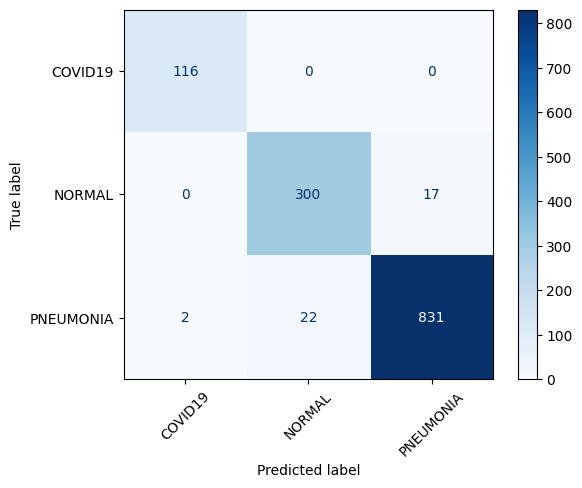

In [27]:
resnet18_config = ExperimentConfig(
    name="resnet18",
    model_fn=lambda: MyResnet(resnet_version='resnet18', n_classes=n_classes),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3)
)      
experiment(resnet18_config, data_dict, device, metrics, freeze=False, epochs=50, mode='results')

Generating results only ...
Best model generated at folder `2`
Loading model `experiments/resnet34_folder\best_resnet34_fold=2.pt`
Evaluating on test dataset...


Classification Report:
              precision    recall  f1-score   support

     COVID19       0.98      1.00      0.99       116
      NORMAL       0.90      0.95      0.93       317
   PNEUMONIA       0.98      0.96      0.97       855

    accuracy                           0.96      1288
   macro avg       0.96      0.97      0.96      1288
weighted avg       0.96      0.96      0.96      1288

Confusion Matrix:


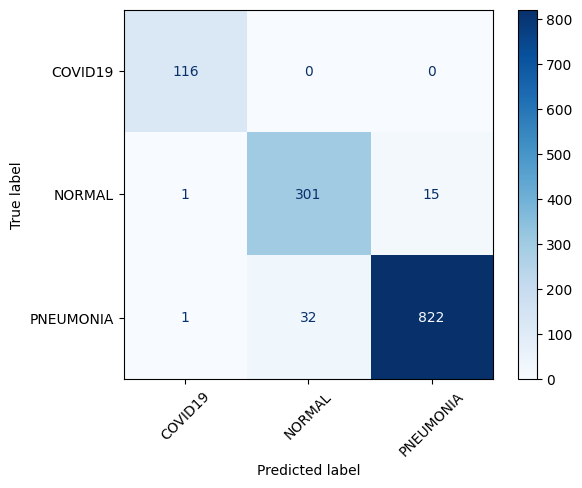

In [28]:
resnet34_config = ExperimentConfig(
    name="resnet34",
    model_fn=lambda: MyResnet(resnet_version='resnet34', n_classes=n_classes),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3)
)
experiment(resnet34_config, data_dict, device, metrics, freeze=False, epochs=50, mode='results')

Generating results only ...
Best model generated at folder `4`
Loading model `experiments/mobilenet_v2_folder\best_mobilenet_v2_fold=4.pt`
Evaluating on test dataset...


Classification Report:
              precision    recall  f1-score   support

     COVID19       0.99      1.00      1.00       116
      NORMAL       0.96      0.92      0.94       317
   PNEUMONIA       0.97      0.99      0.98       855

    accuracy                           0.97      1288
   macro avg       0.98      0.97      0.97      1288
weighted avg       0.97      0.97      0.97      1288

Confusion Matrix:


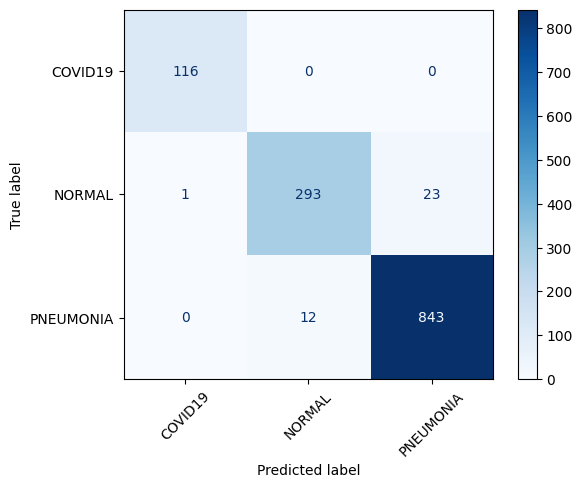

In [29]:
mobilenet_v2_config = ExperimentConfig(
    name="mobilenet_v2",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v2', n_classes=n_classes),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3)
)
experiment(mobilenet_v2_config, data_dict, device, metrics, freeze=False, epochs=50, mode='results')

Generating results only ...
Best model generated at folder `4`
Loading model `experiments/mobilenet_v3_large_folder\best_mobilenet_v3_large_fold=4.pt`
Evaluating on test dataset...


Classification Report:
              precision    recall  f1-score   support

     COVID19       1.00      0.97      0.99       116
      NORMAL       0.94      0.97      0.95       317
   PNEUMONIA       0.98      0.98      0.98       855

    accuracy                           0.98      1288
   macro avg       0.98      0.97      0.97      1288
weighted avg       0.98      0.98      0.98      1288

Confusion Matrix:


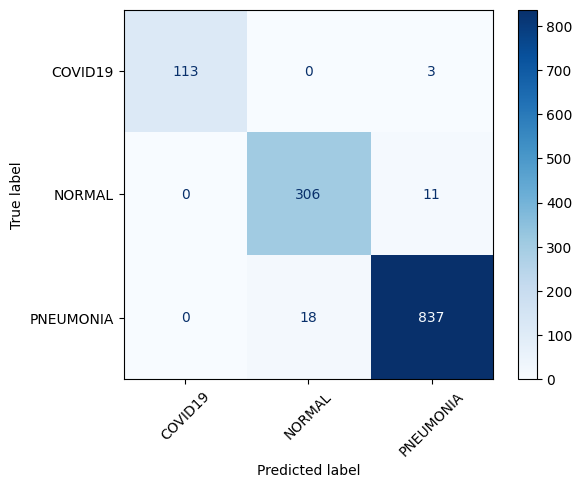

In [30]:
mobilenet_v3_large_config = ExperimentConfig(
    name="mobilenet_v3_large",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v3_large', n_classes=n_classes),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3)
)
experiment(mobilenet_v3_large_config, data_dict, device, metrics, freeze=False, epochs=50, mode='results')

Generating results only ...
Best model generated at folder `1`
Loading model `experiments/densenet121_folder\best_densenet121_fold=1.pt`
Evaluating on test dataset...


Classification Report:
              precision    recall  f1-score   support

     COVID19       1.00      0.97      0.99       116
      NORMAL       0.93      0.91      0.92       317
   PNEUMONIA       0.97      0.97      0.97       855

    accuracy                           0.96      1288
   macro avg       0.96      0.95      0.96      1288
weighted avg       0.96      0.96      0.96      1288

Confusion Matrix:


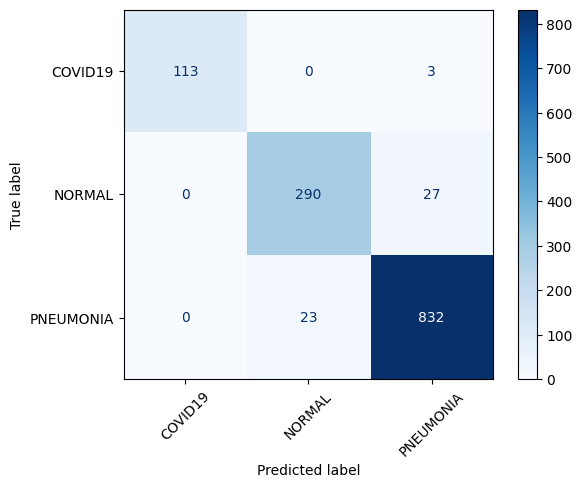

In [31]:
densenet121_config = ExperimentConfig(
    name="densenet121",
    model_fn=lambda: MyDenseNet(densenet_version='densenet121', n_classes=n_classes),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3)
)
experiment(densenet121_config, data_dict, device, metrics, freeze=False, epochs=50, mode='results')

In [32]:
def friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list: list[str], target_column='val_f1_score', alpha=0.05):
    from scipy.stats import friedmanchisquare
    from scikit_posthocs import posthoc_nemenyi_friedman
    
    friedman_data_df = pd.DataFrame()
    
    model_name_list = [] ## to fix order
    
    for experiment_path, model_name in experimentpath_modelname_list:
        _dir = os.listdir(experiment_path)
        result_df_path = [x for x in _dir if '.parquet' in x][-1]
        result_df_path = os.path.join(experiment_path, result_df_path)
        
        result_df = pd.read_parquet(result_df_path)
        result_df_max = result_df.groupby('fold').max().reset_index()
        friedman_data_df[model_name] = result_df_max[target_column]
        
        model_name_list.append(model_name)
    
    friedman_statistic, p_value = friedmanchisquare(*[friedman_data_df[m_name] for m_name in model_name_list])

    if p_value < alpha:
        print(f"friedman p_value=({p_value:.4f}) is lower than alpha={alpha}.")
        print("Doing Posthoc Nemenyi Test...")
        print("-" * 50)

        # Executando o teste post-hoc de Nemenyi
        # A função espera os dados em um formato diferente, por isso usamos o .T (transposta)
        nemenyi_results = posthoc_nemenyi_friedman(friedman_data_df.T)
        nemenyi_results.columns = model_name_list
        
        print(nemenyi_results.round(4))

    else:
        print(f"friedman p_value=({p_value:.4f}) is bigger than alpha={alpha}.")
        print("There is no statistical relevant difference between the models.")

    return    


In [20]:
experimentpath_modelname_list = [
    ('experiments/resnet18_folder/', 'resnet18'),
    ('experiments/resnet34_folder/', 'resnet34'),
    ('experiments/mobilenet_v2_folder/', 'mobilenet_v2'),
    ('experiments/mobilenet_v3_large_folder/', 'mobilenet_v3_large'),
    ('experiments/densenet121_folder/', 'densenet121'),
]

friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list, alpha=0.05)

friedman p_value=(0.0107) is lower than alpha=0.05.
Doing Posthoc Nemenyi Test...
--------------------------------------------------
   resnet18  resnet34  mobilenet_v2  mobilenet_v3_large  densenet121
0    1.0000    0.9307        0.9946              0.2659       0.9751
1    0.9307    1.0000        0.7514              0.7514       0.9996
2    0.9946    0.7514        1.0000              0.1152       0.8555
3    0.2659    0.7514        0.1152              1.0000       0.6277
4    0.9751    0.9996        0.8555              0.6277       1.0000
